Preproces data for computing pca during test period

trial_error:
* 0: correct trial
* 6: false alarm (relase during test period)
* 8: missed target

In [10]:
# Pipeline for preprocessing data for pca analysis
from preproc_tools import get_neuron_sample_test_fr, to_python_hdf5
import glob
import os
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import datetime
import json
from pathlib import Path
import h5py
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ephysvibe.trials import align_trials, select_trials
from ephysvibe.structures.neuron_data import NeuronData

In [2]:
def z_score(X,with_std=False):
    # X: ndarray, shape (n_features, n_samples)
    # X=X/ np.max(X,axis=1).reshape(-1,1)
    ss = StandardScaler(with_mean=True, with_std=with_std)
    Xz = ss.fit_transform(X.T).T
    return Xz,ss

In [3]:
def compute_pca(x, n_comp=50):
    model = PCA(n_components=n_comp)
    # C = model.components_
    # pc_s = C @ x
    pc_s = model.fit_transform(x.T).T
    return model, pc_s

In [4]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [5]:
# Define parameters
filepaths = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/lip/neurons/"
outputpath = "./test/"

area = "lip"
subject = "Riesling"
avgwin = 100
min_sp_sec = 5
n_test = 1
min_trials = 10
nonmatch = True  # if True: includes nonmatch trials

# sample timing
time_before_sample = 500
start_sample = -200
end_sample = 450 + 400

# test timing
time_before_test = 500
start_test = -400
end_test = n_test * 450 + 200
# -------------------------------------------- End parameters ------------------------------------------

# Compute idxs
idx_start_sample = time_before_sample + start_sample
idx_end_sample = time_before_sample + end_sample
idx_start_test = time_before_test + start_test
idx_end_test = time_before_test + end_test
# total trial duration
trial_dur = end_sample - start_sample + end_test - start_test


In [7]:
# ------------------------------------------ Start preprocessing ----------------------------------------
neu_path = filepaths + "*neu.h5"
path_list = glob.glob(neu_path)


In [ ]:
def get_neuron_sample_test_fr(
    path,
    time_before_sample,
    time_before_test,
    idx_start_sample,
    idx_end_sample,
    idx_start_test,
    idx_end_test,
    n_test,
    min_trials,
    nonmatch=True,
    avgwin=50,
    n_sp_sec=5,
):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block = 1
    code = 1
    # Select trials aligned to sample onset
    sp_sample_on, sp_test_on, mask_s, mask_t = select_sample_test_aligned_trials(
        neu_data, select_block, code, time_before_sample, time_before_test, error_type=0
    )
    # Build masks to select trials with match in the n_test
    mask_match = np.where(
        neu_data.test_stimuli[mask_t, n_test - 1] == neu_data.sample_id[mask_t],
        True,
        False,
    )
    mask_neu = neu_data.sample_id[mask_t] == 0
    # Build masks to select trials with the selected number of test presentations
    max_test = neu_data.test_stimuli[mask_t].shape[1]
    mask_ntest = (
        max_test - np.sum(np.isnan(neu_data.test_stimuli[mask_t]), axis=1)
    ) > (n_test - 1)

    if nonmatch:  # include nonmatch trials
        mask_match_neu = np.logical_or(mask_ntest, mask_neu)
    else:
        mask_match_neu = np.logical_or(mask_match, mask_neu)
    if np.sum(mask_match_neu) < 20:
        return {"fr": None}

    # Average fr across time
    avg_sample_on = firing_rate.moving_average(
        sp_sample_on[mask_match_neu], win=avgwin, step=1
    )[:, idx_start_sample:idx_end_sample]
    avg_test1_on = firing_rate.moving_average(
        sp_test_on[mask_match_neu], win=avgwin, step=1
    )[:, idx_start_test:idx_end_test]
    # Concatenate sample and test aligned data
    sp = np.concatenate((avg_sample_on, avg_test1_on), axis=1)
    # Check fr
    ms_fr = np.nanmean(sp) * 1000 > n_sp_sec
    if not ms_fr:
        return {"fr": None}
    # Check number of trials
    sample_id = neu_data.sample_id[mask_t][mask_match_neu]
    samples = [0, 11, 15, 55, 51]
    for s_id in samples:
        sample_fr = sp[np.where(sample_id == s_id, True, False)]
        if sample_fr.shape[0] < min_trials:
            return {"fr": None}
    # Get trials grouped by sample
    fr_samples = select_trials.get_sp_by_sample(sp, sample_id, samples=samples)

    if fr_samples is None:
        return {"fr": None}
    return {"fr": fr_samples}


In [32]:
data = Parallel(n_jobs=-1)(
    delayed(get_neuron_sample_test_fr)(
        path=path,
        time_before_sample=time_before_sample,
        time_before_test=time_before_test,
        idx_start_sample=idx_start_sample,
        idx_end_sample=idx_end_sample,
        idx_start_test=idx_start_test,
        idx_end_test=idx_end_test,
        n_test=n_test,
        min_trials=min_trials,
        nonmatch=nonmatch,
        avgwin=avgwin,
        n_sp_sec=min_sp_sec,
    )
    for path in tqdm(path_list)
)

100%|██████████| 530/530 [11:47<00:00,  1.33s/it]


In [14]:
neu_data = NeuronData.from_python_hdf5(path_list[56])

In [23]:
select_block = 1
code=1
# * 0: correct trial (Hits and Correct rejections)
error_type = 0
# Select trials aligned to sample onset
HCRsp_test_on, HCRmask_t = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block=select_block,
    select_pos=code,
    event="test_on_1",
    time_before=time_before_test,
    error_type=error_type,
)
# * 8: missed target
error_type = 8
# Select trials aligned to sample onset
Msp_test_on, Mmask_t = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block=select_block,
    select_pos=code,
    event="test_on_1",
    time_before=time_before_test,
    error_type=error_type,
)

In [ ]:
# * 6: false alarm (relase during test period)
error_type = 6
before_test = 400
after_test = 400
ntest=neu_data.test_stimuli.shape[1]
ntr = np.logical_and(neu_data.trial_error==error_type,neu_data.block==select_block)
FA_tr_tt = np.full((ntr,ntest,before_test+after_test+460),np.nan)

# Select trials aligned to sample onset
FAsp_test_on, FAmask_t = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block=select_block,
    select_pos=code,
    event="test_on_1",
    time_before=time_before_test,
    error_type=error_type,
)

In [62]:
# FA: bar release before matching test stim presentation
bar_release = 4
test_on_1= 25
test_on_2= 27
sample_on = 23
test_stimuli=neu_data.test_stimuli[FAmask_t]
sample_id=neu_data.sample_id[FAmask_t]
code_samples=neu_data.code_samples[FAmask_t]
code_numbers = neu_data.code_numbers[FAmask_t]
FA_moment = (code_samples[code_numbers==bar_release]-code_samples[code_numbers==test_on_1])
FA_in_test = np.floor(FA_moment/459)
FA_in_test



array([0., 1., 0., 1., 1., 0., 3., 2., 2., 4., 2., 2., 1., 4., 0., 2., 0.,
       1., 1., 3., 4., 0., 2., 1., 0., 1.])

In [64]:
code_samples[np.any(code_numbers==test_on_2,axis=1)][code_numbers[np.any(code_numbers==test_on_2,axis=1)]==test_on_1]-code_samples[code_numbers==test_on_2]

array([-459., -459., -459., -459., -459., -459., -459., -459., -459.,
       -459., -459., -459., -459., -459., -460., -460., -459., -459.,
       -460.])

In [ ]:
sel_idx = np

In [28]:
FAsp_test_on[]

array([5., 0., 0., ..., 3., 4., 4.])

array([1., 2., 1., 2., 2., 1., 4., 3., 3., 5., 3., 3., 2., 5., 1., 3., 1.,
       2., 2., 4., 5., 1., 3., 2., 1., 2.])

In [22]:
# trial_error:



H = 
CR = 
M = 
FA = 


SyntaxError: invalid syntax (1018982603.py, line 1)

In [33]:
seed=1997

In [86]:
s0,s11,s15,s51,s55 = [],[],[],[],[]
g1mean,g2mean=[],[]
gg1=[]
gg2=[]
rng = np.random.default_rng(seed)
s0mean, s11mean, s15mean, s51mean, s55mean,nnmean = [],[],[],[],[],[]
for asc in data:
    fr = asc["fr"]
    if fr is not None:
        s0mean.append(np.mean(fr['0'],axis=0))
        s11mean.append(np.mean( fr['11'],axis=0))
        s15mean.append(np.mean( fr['15'],axis=0))
        s51mean.append(np.mean( fr['51'],axis=0))
        s55mean.append(np.mean( fr['55'],axis=0))
        nn=np.concatenate((fr['11'],fr['15'],fr['51'],fr['55']),axis=0)
        nnmean.append(np.mean(nn,axis=0))

        
        nn_idx_tr = rng.choice(len(nn), size=10, replace=False)


        allsampl = nn=np.concatenate((fr['0'],fr['11'],fr['15'],fr['51'],fr['55']),axis=0)

        n_idx_tr = rng.choice(len(allsampl), size=40, replace=False)

        g1mean.append(np.mean(allsampl[n_idx_tr[:20]],axis=0))
        g2mean.append(np.mean(allsampl[n_idx_tr[20:]],axis=0))


neurons_fr=[{'0mean':s0mean,'11mean':s11mean,'15mean':s15mean,'51mean':s51mean,'55mean':s55mean,'nnmean':nnmean,'g1mean':g1mean,'g2mean':g2mean}]

In [87]:
to_python_hdf5(dat=neurons_fr, save_path='trials_wintr_pca88.h5')

In [60]:
aa=from_python_hdf5('trials_wintr_pca88.h5')[0]

In [36]:
path_list=['trials_wintr_pca88.h5']

In [40]:
n_comp=100

In [88]:
pc_areas = {}
for path,area in zip(path_list,['lip']):#'lip',
    fr=from_python_hdf5(path)[0]
    fr_concat = np.concatenate((fr['0mean'],fr['11mean'],fr['15mean'],fr['51mean'],fr['55mean']),axis=1)
    fr_group_concat = np.concatenate((fr['g1mean'],fr['g2mean']),axis=1)

    print('%s %d'%(area,fr_concat.shape[0]))

    fr_concat,ss = z_score(fr_concat,with_std=False)
    fr_group_concat=ss.fit_transform(fr_group_concat.T).T
    model,pc_s = compute_pca(fr_concat,n_comp=n_comp)
    pc_areas[area] = {'model':model,'pc':pc_s,'n_neurons':fr_concat.shape[0],'allsamples_fr':fr_concat,'n_fr':fr['0mean'],'nn_fr':fr['nnmean'],'fr_group_concat':fr_group_concat}

lip 202


In [89]:
from scipy.spatial.distance import pdist
from ephysvibe.stats import smetrics

In [94]:
res={'lip':{},'v4':{},'pfc':{}}
rng = np.random.default_rng(seed)
for area in ['lip']:
    all_distn=[]
    all_distnn=[]
    all_dist_n_nn=[]
    n_comp=100
    allidx_neu=[]
    allreshape_pc=[]
    alldist_fake_n_nn=[]
    tot_nneu=pc_areas[area]['n_neurons']
    for _ in range(100):
        idx_neu = rng.choice(tot_nneu, size=n_comp, replace=False)
        allidx_neu.append(idx_neu)
        allsamp_fr=pc_areas[area]['allsamples_fr'][idx_neu]
        fr_group_concat=pc_areas[area]['fr_group_concat'][idx_neu]
    


        n_fr = pc_areas[area]['n_fr'][idx_neu]
        nn_fr = pc_areas[area]['nn_fr'][idx_neu]
        # neurons_fr=np.concatenate((n_fr,nn_fr),axis=1)

        model,pc_s= compute_pca(allsamp_fr,n_comp=n_comp)
        reshape_pc = pc_s.reshape(n_comp,5,-1)
        reshape_pc=np.concatenate((reshape_pc[:,0],np.mean(reshape_pc[:,1:],axis=1)),axis=1).reshape(n_comp,2,-1)
        # pc_s =model.transform(np.concatenate((n_fr,nn_fr),axis=1).T).T
        # reshape_pc = pc_s.reshape(n_comp,2,-1)
        pc_groups = model.transform(fr_group_concat.T).T
        pc_groups=pc_groups.reshape(n_comp,2,-1)
        distn=[]
        distnn=[]
        dist_n_nn=[]
        dist_fake_n_nn=[]
        for i in range(reshape_pc.shape[-1]):
            #dist.append(signed_euclidean_distance(nnpc[:,i].T, npc[:,i].T))
            reference = np.zeros(n_comp) # allsamp_pc[:,i] # 
            distn.append(pdist(np.array((reshape_pc[:,0,i],reference))))
            distnn.append(pdist(np.array((reshape_pc[:,1,i],reference))))
            dist_n_nn.append(pdist(np.array((reshape_pc[:,0,i],reshape_pc[:,1,i]))))
            dist_fake_n_nn.append(pdist(np.array((pc_groups[:,0,i],pc_groups[:,1,i]))))

        all_distn.append(np.array(distn).reshape(-1))
        all_distnn.append(np.array(distnn).reshape(-1))
        all_dist_n_nn.append(np.array(dist_n_nn).reshape(-1))
        alldist_fake_n_nn.append(np.array(dist_fake_n_nn).reshape(-1))
    all_distn=np.array(all_distn)
    all_distnn=np.array(all_distnn)
    all_dist_n_nn=np.array(all_dist_n_nn)
    alldist_fake_n_nn=np.array(alldist_fake_n_nn)
    # group1=all_distnn
    # group2=all_distn
    group1=all_dist_n_nn
    group2=alldist_fake_n_nn
    roc_score, p = smetrics.compute_roc_auc(group1, group2)
    latency,_=smetrics.find_latency(
        p_value=p, win=75, step= 1, p_treshold= 0.05
    )
    res[area]['roc_score']=roc_score
    res[area]['latency']=latency
    res[area]['p']=p
    res[area]['all_distnn']=all_distnn
    res[area]['all_distn']=all_distn
    res[area]['allidx_neu']=allidx_neu
    res[area]['all_dist_n_nn']=all_dist_n_nn
    res[area]['alldist_fake_n_nn']=alldist_fake_n_nn
    print(area)
    print(latency-200)

lip
-200


In [95]:
import matplotlib.pyplot as plt

lip
-200


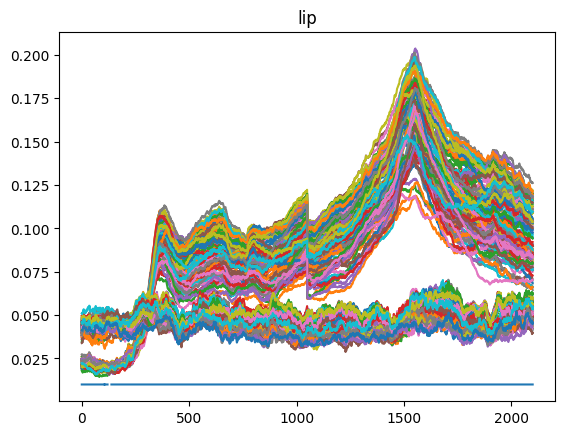

In [96]:
for area in ['lip']:
    d=res[area]['all_dist_n_nn']
    d_fix = d[:,:200]
    x_bar = np.mean(d_fix) 
    s = np.std(d_fix) 
    n = n_comp # number of obs
    z = 1.96 # for a 95% CI

    lower = x_bar - (z * (s/np.sqrt(n)))
    upper = x_bar + (z * (s/np.sqrt(n)))
    med = np.median(d_fix)
    sig=np.where(np.sum(d>upper,axis=0)/10 > 0.95,1,np.nan)
    _=plt.figure()
    _=plt.plot(d.T)
    _=plt.plot(sig/100)
    # _=plt.hlines(upper,0,2100)
    # _=plt.vlines(200,0,0.2)
    # _=plt.vlines(200+100,0,0.2)
    p=res[area]['alldist_fake_n_nn']
    _=plt.plot(p.T)
    _=plt.title(area)
    print(area)
    print(np.where(sig==1)[0][0]-200)

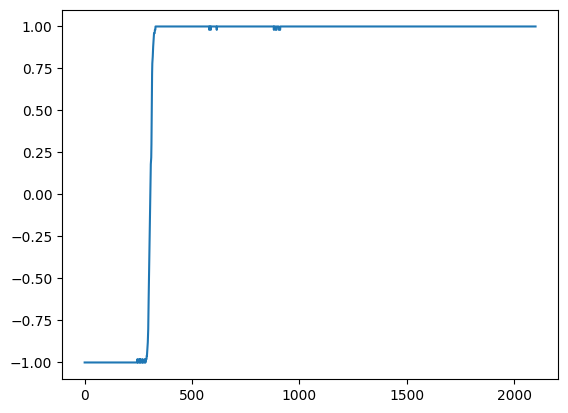

In [97]:
plt.plot(res[area]['roc_score'])